# Scatterometry Demo

![scat_setup](../img/scat_setup.png)

## Load Packages

In [1]:
from contextlib import contextmanager
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import emcee
import pythia as pt

## Load Scatterometry Data

In [2]:
path = "../data/scat/"

# load all data
x_data = np.load(path+"x_train.npy")  # (10_000, 6)
y_data = np.load(path+"y_train.npy")  # (90, 10_000, 2)
w_data = np.load(path+"w_train.npy")  # (10_000, )
angles = np.load(path+"angles.npy")  # (90, 2)

# reshape y_data
y_data = np.concatenate([y_data[:45,:,0], y_data[:45,:,1],
                         y_data[45:,:,0], y_data[45:,:,1]], axis=0).T  # (10_000, 180)
angles = np.concatenate([angles, angles], axis=0)  # (180, 2)
angle_idxs = [range(45), range(45,90), range(90,135), range(135,180)]
angle_labels = ["$\phi=0^\circ$, s pol","$\phi=0^\circ$, p pol",
                     "$\phi=90^\circ$, s pol","$\phi=90^\circ$, p pol"]

# load parameter information
params = []
for dct in np.load(path+"parameter.npy", allow_pickle=True):
    params.append(pt.parameter.RandomParameter(
        name=dct["_name"], domain=dct["_dom"], distribution=dct["_dist"],
        alpha=dct["_alpha"], beta=dct["_beta"]))

In [3]:
idx = int(0.8*x_data.shape[0])

# training data
x_train = x_data[:idx]
y_train = y_data[:idx]
w_train = w_data[:idx]

# test data
x_test = x_data[idx:]
y_test = y_data[idx:]

# measurement
x_true = x_data[-1].reshape(1, -1)
y_true = y_data[-1].reshape(1, -1)
b = 0.02
noise = np.random.normal(0, b, y_true.shape)
y_meas = y_true + noise

In [4]:
print("parameter  dist    domain")
print("-"*30)
for param in params:
    print(f"{param.name:<9}  {param.distribution:<5}   {np.array(param.domain, dtype=int)}")

parameter  dist    domain
------------------------------
h          beta    [43 53]
cd         beta    [22 28]
swa        beta    [84 90]
t          beta    [4 6]
r_top      beta    [ 8 13]
r_bot      beta    [3 7]


In [5]:
fig = plt.figure()
for idxs, label in zip(angle_idxs, angle_labels):
    plt.plot(angles[idxs,1], y_true[0,idxs], label=label)
    plt.scatter(angles[idxs,1], y_meas[0, idxs], s=2)
    plt.legend()
    plt.title("Ground truth (solid) and noisy measurement (dots)")
plt.show()

## Train PC Surrogate

In [6]:
# define multiindices
deg = 4
mdx = pt.index.PCMultiIndex(len(params))
mdx.mdx = mdx.mdxFromShape([deg]*len(params))  # tensor set up to (including) deg
mdx.mdxLimitAbs(deg)  # cut all mdx with total degree larger then deg
mdx.mdx = np.unique(np.concatenate(  # add tensor set up to (including) deg 1 for coverage
    [mdx.mdx, mdx.mdxFromShape([1]*len(params))], axis=0), axis=0)
mdx.refresh()  # update information on sobol indices
print(mdx)

mdx    dim     : 6
       count   : 217
       dim max : [4 4 4 4 4 4]
       max abs : 4
sdx    count   : 63


In [7]:
# run pc approximation
%timeit pt.chaos.PolynomialChaos(params, mdx, x_train, w_train, y_train)
pc = pt.chaos.PolynomialChaos(params, mdx, x_train, w_train, y_train)

1.17 s ± 26.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# test approximation error
y_approx = pc.approximation(x_test)

# L2-L2 error
err_abs = np.sum(np.linalg.norm(y_test - y_approx, axis=1))/y_test.shape[0]
err_rel = np.sum(np.linalg.norm((y_test - y_approx)/y_test, axis=1))/y_test.shape[0]
print(f"L2-L2 error: {err_abs:4.2e} (abs), {err_rel:4.2e} (rel)")

# C0-L2 error
err_abs = np.sum(np.max(np.abs(y_test - y_approx), axis=1))/y_test.shape[0]
err_rel = np.sum(np.max(np.abs(y_test - y_approx)/np.abs(y_test), axis=1))/y_test.shape[0]
print(f"L2-C0 error: {err_abs:4.2e} (abs), {err_rel:4.2e} (rel)")

L2-L2 error: 1.07e-02 (abs), 2.08e-02 (rel)
L2-C0 error: 5.58e-03 (abs), 7.63e-03 (rel)


## Global Sensitivity Analysis

In [9]:
max_vals = np.max(pc.sobolCoeff, axis=1)
l2_vals = np.linalg.norm(pc.sobolCoeff, axis=1)

In [10]:
sdx_max = [list(reversed([x for _,x in sorted(zip(max_vals, pc.mdx.sdx))]))]
sdx_L2 = [list(reversed([x for _,x in sorted(zip(l2_vals, pc.mdx.sdx))]))]

print(f"{'#':>2}  {'max':<10}  {'L2':<10}")
print("-"*25)
for j in range(10):
    print(f"{j+1:>2}  {str(sdx_max[0][j]):<10}  {str(sdx_L2[0][j]):<10}")

 #  max         L2        
-------------------------
 1  (2,)        (2,)      
 2  (4,)        (4,)      
 3  (1,)        (1,)      
 4  (3,)        (3,)      
 5  (2, 5)      (2, 5)    
 6  (5,)        (5,)      
 7  (3, 5)      (3, 5)    
 8  (2, 3, 5)   (6,)      
 9  (6,)        (2, 3, 5) 
10  (1, 2)      (2, 3)    


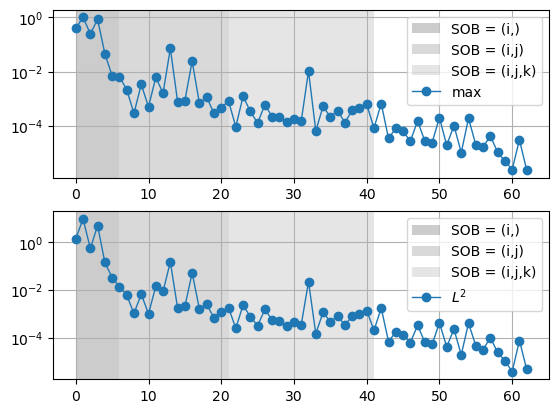

In [11]:
def binom(n,k): 
    return np.math.factorial(n) / np.math.factorial(k) / np.math.factorial(n-k)
bdry = [0]*7
for jj in range(1,len(bdry)):
    bdry[jj] = int(bdry[jj-1] + binom(len(bdry)-1,jj))
    
fig, axes = plt.subplot_mosaic([["max"], ["L2"]])

axes["max"].axvspan(bdry[0], bdry[1], facecolor="k", alpha=0.2, label="SOB = (i,)")
axes["max"].axvspan(bdry[1], bdry[2], facecolor="k", alpha=0.15, label="SOB = (i,j)")
axes["max"].axvspan(bdry[2], bdry[3], facecolor="k", alpha=0.1, label="SOB = (i,j,k)")
axes["max"].semilogy(range(pc.sobolCoeff.shape[0]), max_vals,
                     "-o", linewidth=1, label="max")
axes["max"].legend()
axes["max"].grid()

axes["L2"].axvspan(bdry[0], bdry[1], facecolor="k", alpha=0.2, label="SOB = (i,)")
axes["L2"].axvspan(bdry[1], bdry[2], facecolor="k", alpha=0.15, label="SOB = (i,j)")
axes["L2"].axvspan(bdry[2], bdry[3], facecolor="k", alpha=0.1, label="SOB = (i,j,k)")
axes["L2"].semilogy(range(pc.sobolCoeff.shape[0]), l2_vals,
                     "-o", linewidth=1, label="$L^2$")
axes["L2"].legend()
axes["L2"].grid()

plt.show()

## Inverse Problem & Parameter Reconstruction

In [13]:
# define forward and error model
hyper_params = [pt.parameter.RandomParameter("b", [0, 0.1], "uniform")]
dim = len(params+hyper_params
         )
prior = pt.sampler.ParameterSampler(params+hyper_params)  # extended prior
forward_model = lambda x: pc.approximation(x[:,:-1])  # extended forward model
sigma = lambda x: np.abs(x[:, -1]).reshape(-1, 1)*np.ones((1, y_meas.shape[1]))  # error model

# define Bayesian posterior
lh = pt.likelihood.Gaussian(forward_model, sigma, dim)
def log_posterior(x, meas):
    return lh.log_likelihood(x, meas) + prior.log_pdf(x)

In [14]:
# setup MCMC
n_walkers = 50
chain_length = 100
seed = prior.sample(n_walkers)

# define runner
runner = emcee.EnsembleSampler(n_walkers, dim, log_posterior, args=[y_meas])

# discard burn-in
print("run burn-in")
state = runner.run_mcmc(seed, 100, progress=True)
runner.reset()

# run MCMC
print("run MCMC")
runner.run_mcmc(state, chain_length, progress=True);

# simple evaluation
samples = runner.get_chain(flat=True)
mean = np.mean(samples, axis=0)
std = np.std(samples, axis=0)

run burn-in


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


run MCMC


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


## Data Analysis

In [15]:
# plot posterior distribution
samples = runner.get_chain(flat=True)
layout = [[j] for j in range(7)]
layout = [[0, 1], [2, 3], [4, 5], [6, 6]]
fig, axes = plt.subplot_mosaic(layout, figsize=(12, 7.5))
for j, (param, ax) in enumerate(zip(params+hyper_params, axes.values())):
    bins = 50 if param.name != "b" else 150
    ax.hist(samples[:, j], bins=bins, density=True, range=param.domain, alpha=0.5)
    ax.axvline(x=mean[j], color=cmap.tab10(0), label="mean")
    ax.axvline(x=mean[j]-std[j], ls="--", color=cmap.tab10(0), label="std")
    ax.axvline(x=mean[j]+std[j], ls="--", color=cmap.tab10(0))
    if param.name == "b":
        ax.axvline(x=b, color="k", label="true value")
    else:  
        ax.axvline(x=x_true[0, j], color="k", label="true value")
    ax.set_ylabel(f"{j+1} - {param.name}")
    ax.set_yticks([])
    ax.legend()
plt.show()

In [16]:
fig, axes = plt.subplot_mosaic([["approx", "error"]], figsize=(15, 5))
vals = pc.approximation(np.mean(samples, axis=0)[:-1])
errs = y_true - vals
for j, (idxs, label) in enumerate(zip(angle_idxs, angle_labels)):
    color = cmap.tab10(j)
    axes["approx"].plot(angles[idxs,1], vals[0, idxs], color=color, label=label)
    axes["approx"].plot(angles[idxs,1], y_true[0, idxs], "--", color=color)
    axes["approx"].scatter(angles[idxs,1], y_meas[0, idxs], s=2, color=color)
    axes["approx"].legend()
    axes["approx"].set_title("Ground truth (solid) and noisy measurement (dots)")
    
    axes["error"].plot(angles[idxs, 1], errs[0, idxs], color=color, label=label)
    axes["error"].legend()
    axes["error"].grid()
    axes["error"].set_title("Pointwise deviation from ground truth")
plt.show()